# 結果の可視化用コード

## 1.前準備

### モジュールのインポート

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_absolute_error
from scipy import stats

### 関数の定義

In [2]:
### 自由度調整済み決定係数
def adj_r2_score(y_true, y_pred, p):
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)

### 初期設定

In [7]:
relative_path = './deeplearning_heat-stroke/model_infomation/'
model_names = ['future_ep1000_ba16_ts60_tmon7-8_屋外人流比率', 'future_ep1000_ba16_ts60_tmon7-8_屋外_v2', 'future_ep1000_ba16_ts60_tmon7-8_屋外人流比率_v2', 'future_ep1000_ba16_ts60_tmon7-8_屋外湿日_v2', 'future_ep1000_ba16_ts60_tmon7-8_屋外人流比率湿日_v2', 'future_ep1000_ba16_ts60_tmon6-9_屋外_v2', 'future_ep1000_ba16_ts60_tmon6-9_屋外人流比率_v2', 'future_ep1000_ba16_ts60_tmon6-9_屋外人流比率湿日_v2']
seeds = ['100', '200', '300', '400', '500']
start_year = 2020
end_year = 2022
colors = ['b', 'r', 'y', 'g', 'bk']

### 結果の統合
並列計算のため、seed値毎で結果を算出しているため、ここで全シード値の結果を統合する

In [8]:
# merge_result
model_dict = {}
for model_name in model_names:
    if '_month7-8_m' in model_name:
        model_title = model_name[:-2]
        if 'ward' in model_name:
            usecols = [1,2,3,4]
        else:
            usecols = [1,2,3]
        if i == 0:
            result_df_original = pd.read_csv(f'{relative_path}{model_name}/{seed}/result/result_{model_title}.csv', usecols=usecols)
        else:
            _df = pd.read_csv(f'{relative_path}{model_name}/{seed}/result/result_{model_title}.csv', usecols=usecols)
            result_df_original[seed] = _df[seed]
    else:
        for i, seed in enumerate(seeds):
            if 'ward' in model_name:
                usecols = [1,2,3,4]
            else:
                usecols = [1,2,3]
            if i == 0:
                result_df_original = pd.read_csv(f'{relative_path}{model_name}/{seed}/result/result_{model_name}.csv', usecols=usecols)
            else:
                _df = pd.read_csv(f'{relative_path}{model_name}/{seed}/result/result_{model_name}.csv', usecols=usecols)
                result_df_original[seed] = _df[seed]
    for seed in seeds:
        result_df_original[seed] = np.where(result_df_original[seed]<0, 0, result_df_original[seed])
    result_df_original['Average'] = result_df_original[seeds].mean(axis=1)
    result_df_original['Date'] = pd.to_datetime(result_df_original['Date'])
    result_df_original['Year'] = result_df_original['Date'].dt.year
    result_df_original['Month'] = result_df_original['Date'].dt.month
    result_df_original['Day'] = result_df_original['Date'].dt.day
    # if ('6-9'or'baseline_ward_future_epoch500_batch32_timestep40') in model_name:
    #result_df_original = result_df_original[result_df_original['Month'].isin([7,8])].reset_index(drop=True)
    if 'ward' in model_name:
        columns_list = ['Date', 'Ward', 'Year', 'Month', 'Day', 'Observed']+seeds+['Average']
    else:
        columns_list = ['Date',  'Year', 'Month', 'Day', 'Observed']+seeds+['Average']
    result_df_original = result_df_original[columns_list]

    # get_result
    result_dict = {}
    if 'ward' in model_name:
        for ward in wards:
            if ward == 'Nagoya':
                _df = result_df_original.groupby(['Date', 'Year', 'Month', 'Day']).sum().reset_index()
            else:
                _df = result_df_original[result_df_original['Ward']==ward].reset_index()
            result_dict[ward] = _df
        model_dict[model_name] = result_dict
    else:
        result_dict['Nagoya'] = result_df_original
        model_dict[model_name] = result_dict

## 2.結果の可視化

### 評価指標の算出
MAEとAdjR2の2つの指標で評価

In [ ]:
#evaluation
for model_name in model_names:
    evalation_dict = {}
    #for ward in wards:
    for ward in wards:
        if (ward != 'Nagoya')&('ward' not in model_name):
            pass
        else:
            mae_df = pd.DataFrame()
            r2_df = pd.DataFrame()
            _df =  model_dict[model_name][ward]
            for y in range(start_year, end_year+1):
                __df = _df.query(f'Year=={y}')
                for seed in seeds+['Average']:
                    mae_df.loc[y, seed] = mean_absolute_error(__df['Observed'], __df[seed])
                    r2_df.loc[y, seed] = adj_r2_score(__df['Observed'], __df[seed], 2)
            for col in r2_df.columns:
                r2_df[col] = np.where(r2_df[col]<0, 0, r2_df[col])
            mae_df.loc['Average', :] = mae_df.mean(axis=0)
            r2_df.loc['Average', :] = r2_df.mean(axis=0)
            evalation_dict[f'{ward}_r2'] = r2_df
            evalation_dict[f'{ward}_mae'] = mae_df
            # print(ward)
            # print('MAE')
            # display(mae_df)
            # print('R2')
            # display(r2_df)
            # print('\n\n')
        
    mae_overview = pd.DataFrame()
    r2_overview = pd.DataFrame()
    for ward in wards:
        if (ward != 'Nagoya')&('ward' not in model_name):
            pass
        else:
            mae_overview[ward] = evalation_dict[f'{ward}_mae']['Average']
            r2_overview[ward] = evalation_dict[f'{ward}_r2']['Average']
    print(model_name)
    print('mae')
    display(mae_overview)
    print('R2')
    display(r2_overview)
    print('\n\n\n')

### 予測結果の可視化
今回は、人流データの考慮の有無による精度の違いを確認している  
グラフより、人流考慮時(赤)の方が精度が高いことが分かる

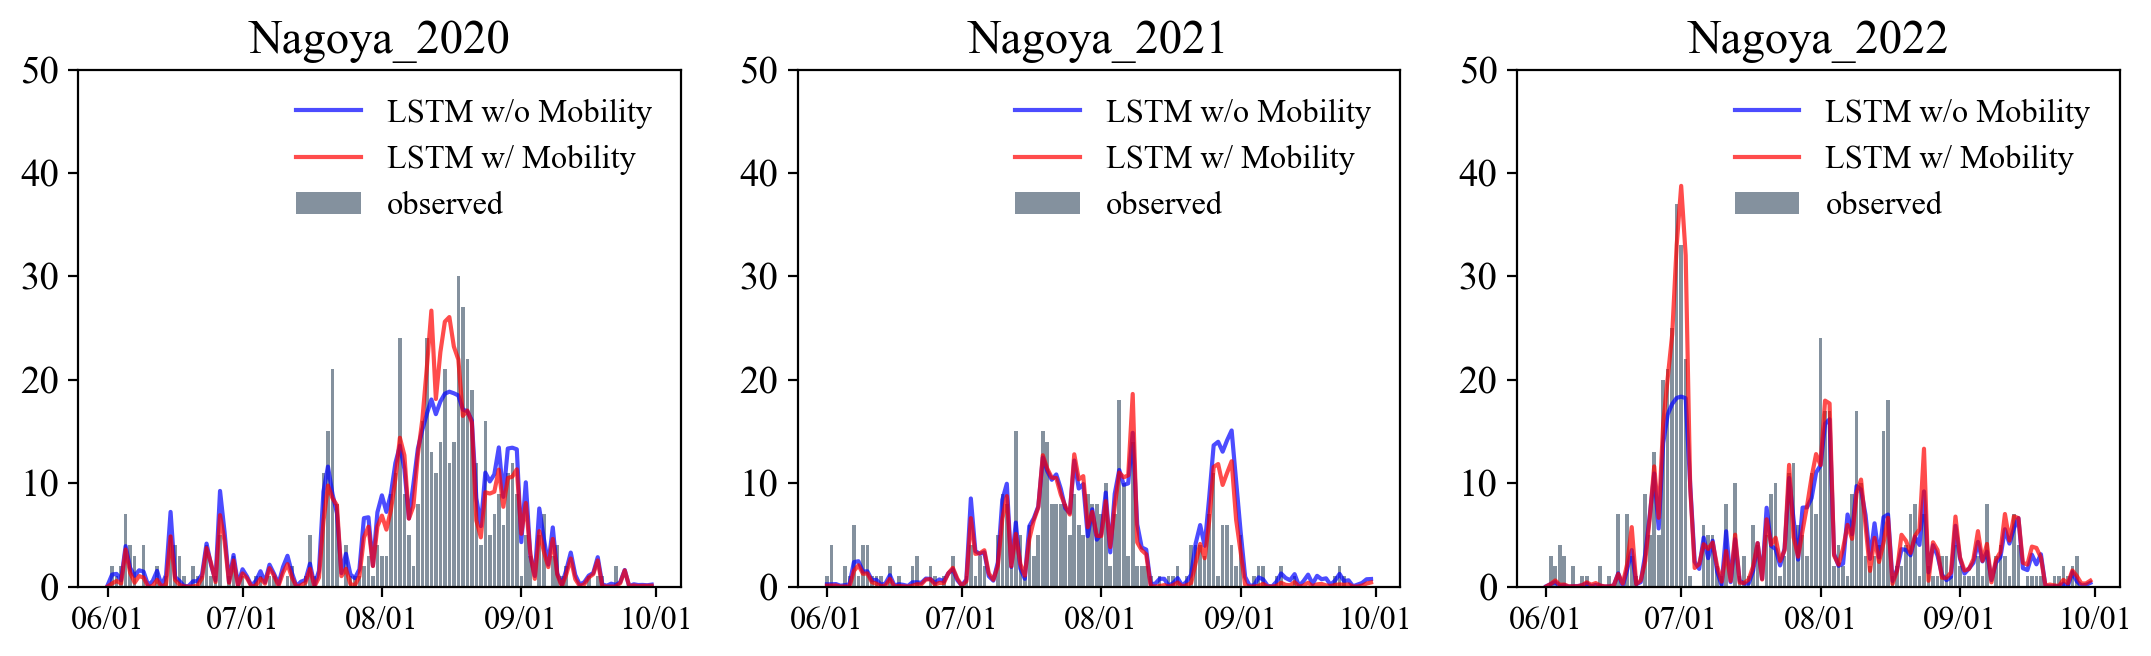

In [44]:
#visualization_E
stay_population = pd.read_csv('../input/stay_population_Nagoya-Station.csv')
pair_name_dict = {'future_ep1000_ba16_ts60_tmon7-8_屋外_v2':'LSTM w/o Mobility', 'future_ep1000_ba16_ts60_tmon7-8_屋外人流比率_v2':'LSTM w/ Mobility'}
asis = 122  #解析日数
plt.rcParams["font.family"] = 'Times New Roman' 
plt.rcParams["font.size"] = 14
plt.rc('legend', fontsize=18)
fig = plt.figure(figsize=(11,3.5),dpi=200)
ward = 'Nagoya'
for j, y in enumerate(range(start_year, end_year+1)):
    ax=fig.add_subplot(1,3,j+1)
    time = pd.date_range(f'2014-06-01 00:00:00',periods=asis,freq='d')
    for i, pair in enumerate(['future_ep1000_ba16_ts60_tmon7-8_屋外_v2', 'future_ep1000_ba16_ts60_tmon7-8_屋外人流比率_v2']):
        __df = model_dict[pair]['Nagoya'].query(f'Year=={y}')
        if i == 0:
            plt.bar(time,__df[f'Observed'].values,label="observed",color="#84919E")# 実際の搬送者数
        ax.plot(time,__df[f'Average'].values,color=colors[i],linestyle = "solid",label=pair_name_dict[pair], alpha=0.7)
    # ax.plot(time,_future[f'pred_ori_inout_sp'].values,color='g',linestyle = "solid",label='fomula', alpha=0.8)
    ax.set_xticks(time)
    ax.set_xticklabels(time,size="small")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.grid()
    # plt.xlabel("Day")
    # plt.ylabel("Number of patients")
    plt.title(f'{ward}_{y}')
    if ward == 'Nagoya':
        y_lim_max = 50
    else:
        y_lim_max = 20
    plt.ylim(0,y_lim_max)
    plt.legend(frameon=False, fontsize='small')
plt.tight_layout()
plt.show()
